<h1 align="center">Optimal Hedging with Advanced Greeks</h1>


<h3 align="center">The workflow</h3>


| Parts  |                         Workflow                         |                                                                                                                                                                      Notes |
| :----- | :------------------------------------------------------: | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------: |
| Part 1 | Simple Volatility Arbitrage but improved Asset Evolution | - Improvement to Monte Carlo simulation <br/> - Pseudo Random Numbers vs Quasi Random numbers<br/> - Monte Carlo Simultion with various methods<br/> - Simulations of PnLt |
| Part 2 |                     Advanced Greeks                      |                                                                                                                                                   - Minimum Variance delta |
| Part 3 |                Local Volatility addition                 |                                                                                                                                                - Dupire Volatility surface |


In [1]:
# library
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.stats import qmc
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [14.0, 10.0]
matplotlib.rcParams["font.size"] = 11
matplotlib.rcParams["lines.linewidth"] = 1.0

# Part 1 - Simple Volatility Arbitrage but improved Asset Evolution

## 1.1 - Improvement to Monte Carlo simulation

### Pseudo Random Numbers vs Quasi Random numbers

Pseudo-random numbers are numbers that are generated by a deterministic algorithm, but appear to be random and uniformly distributed. They are commonly used in Monte Carlo simulation because they are easy to produce and have good statistical properties. However, pseudo-random numbers have some drawbacks, such as periodicity, correlation and clustering.Quasi-random numbers are numbers that are generated by a deterministic algorithm, but are designed to be more evenly distributed than pseudo-random numbers. They are also called low-discrepancy sequences, because they have a low measure of discrepancy, which is a way of quantifying how uniformly a set of points covers a domain. Quasi-random numbers are often used in Monte Carlo simulation because they can achieve faster convergence and better accuracy than pseudo-random numbers.


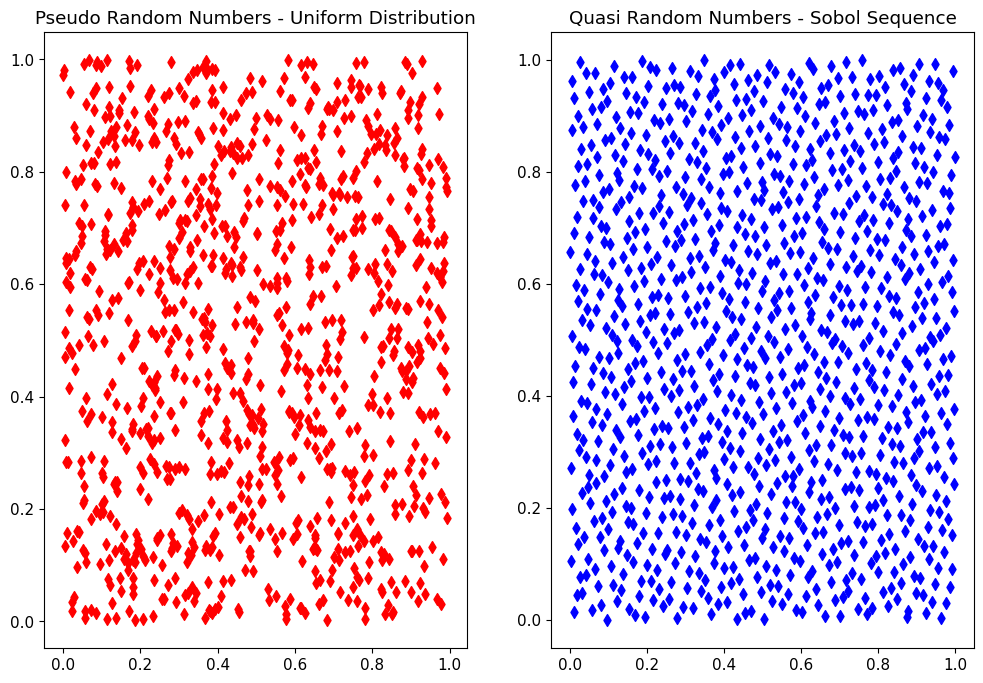

In [2]:
# Pseudo Random Numbers vs Quasi Random Numbers
n = 1024  # Number of points (consistent with the number of points in the Sobol sequence (2^n))
ps_y_axis = np.random.uniform(0, 1, int(n))  # Pseudo Random Numbers generation
ps_x_axis = np.random.uniform(0, 1, int(n))  # Pseudo Random Numbers generation


# Quasi Random Numbers generation with Sobol sequence
def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)


def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)


x = sobol(m=10, d=2).T

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax1.scatter(ps_x_axis, ps_y_axis, color="red", marker="d")
ax1.set_title("Pseudo Random Numbers - Uniform Distribution")

ax2.scatter(x[0], x[1], color="blue", marker="d")
ax2.set_title("Quasi Random Numbers - Sobol Sequence")

plt.show()

With Quazi random number we get a much better even distribution and we do not have this effect of clustering that we find in pseudo random numbers


### Monte Carlo Simultion with various methods

We have seen that it is assumed that stock price follows the Geometric Brownian Motion also denominated as GBM, written mathematically by :

$$ dS*{t} = rS*{t}dt + σS*{t}dW*{t} $$

where:

- $dt$ - is the time step,
- $S_{t}$ - is the price of the underlying at time $t$,
- $\sigma$ - is constant volatility,
- $r$ - is the constant risk-free interest rate,
- $W$ - is the brownian motion or Wiener process.

Applying Euler discretization of SDE, we get:

$$ S_{t+{\delta}t} = S_t \exp^{(1 + r \delta t + \sigma \sqrt{\delta t} wt)}$$

The Forward Euler-Maruyama methods for GBM is given by:

$$ S_{t+dt} - S_t = rS*{t}dt + \sigma\_{t}\phi\sqrt{dt}$$

We can also re write it in a more convinient way by the following:

$$ S_{t+\delta t}=S_t \exp ^{\left(\left(r-\frac{1}{2} \sigma^2\right) \delta t+\sigma \sqrt{\delta t}  w_t\right)} $$

where:

- **$\phi$** - is a standard normal random number meaning, $\phi \sim N(0,1)$

* add more math on monte carlo and sobol


In [3]:
def simulate_path(
    initial_stock_price: float,
    risk_free_rate: float,
    sigma: float,
    horizon: int,
    timesteps: int,
    simulations: int,
    method: str,
) -> np.ndarray:
    """
    :param initial_stock_price: Initial stock price
    :param risk_free_rate: Rf in risk neutral framework
    :param sigma: Stock's volatility
    :param horizon: Time horizon for the simulation
    :param timesteps: Number of time steps for the simulation
    :param simulations: Number of simulation
    :param method: Which method for the simulation (Euler-Maruyama, Euler-Maruyama_antithetic, Sobol_Euler)
    :return: ndarray of simulations
    """

    # Parameter initialization

    dt = horizon / timesteps  # length of time interval

    # Simulating 'n' asset price paths with 't' timesteps
    stock_price = np.zeros((timesteps, simulations))
    stock_price[0] = initial_stock_price

    match method:
        case "Euler":
            # Euler–Maruyama method
            for i in range(0, timesteps - 1):
                # Generate pseudo standard normal random numbers
                wiener_process = np.random.standard_normal(simulations).T
                # vectorized operation for each timesteps
                stock_price[i + 1] = stock_price[i] * (
                    1 + risk_free_rate * dt + sigma * np.sqrt(dt) * wiener_process
                )

        case "Euler_Antithetic":
            # Euler–Maruyama method with Antithetic Variates
            for i in range(0, timesteps - 1):
                # Generate standard normal pseudo random numbers
                wiener_process_1 = np.random.standard_normal(int(simulations / 2)).T
                wiener_process_f = np.concatenate(
                    (wiener_process_1, -wiener_process_1), axis=0
                ).copy()
                # vectorized operation for each timesteps
                stock_price[i + 1] = stock_price[i] * (
                    1 + risk_free_rate * dt + sigma * np.sqrt(dt) * wiener_process_f
                )

        case "Sobol_Euler":
            sobol_num = qmc.Sobol(d=timesteps, scramble=True)
            # Generate M quasi-random numbers from the Sobol instance
            u = sobol_num.random(n=simulations)
            # Transform the quasi-random numbers to standard normal using the inverse CDF
            z = norm.ppf(u)
            # Calculate the increments of the GBM process
            drift = (risk_free_rate - 0.5 * sigma**2) * dt  # drift term
            diffusion = sigma * np.sqrt(dt) * z  # diffusion term
            increments = drift + diffusion
            # Simulate the prices by multiplying the initial price by the cumulative product of the increments
            stock_price = initial_stock_price * np.exp(np.cumsum(increments, axis=1))
            # Add the initial price as the first column of the prices array
            stock_price = np.column_stack(
                [initial_stock_price * np.ones(simulations), stock_price]
            )
            stock_price = stock_price.T

        case _:
            raise TypeError(f"Invalid Method type : {method}")

    return stock_price

In [4]:
sim_e_path = pd.DataFrame(
    simulate_path(100, 0.05, 0.35, 1, 252, 16384, "Euler")
)
sim_ea_path = pd.DataFrame(
    simulate_path(100, 0.05, 0.35, 1, 252, 16384, "Euler_Antithetic")
)
sim_se_path = pd.DataFrame(
    simulate_path(100, 0.05, 0.35, 1, 252, 16384, "Sobol_Euler")
)

### Plots (simulated path and histogram)

Here I present the simulated path for the three methods and the histogram of the final time step.


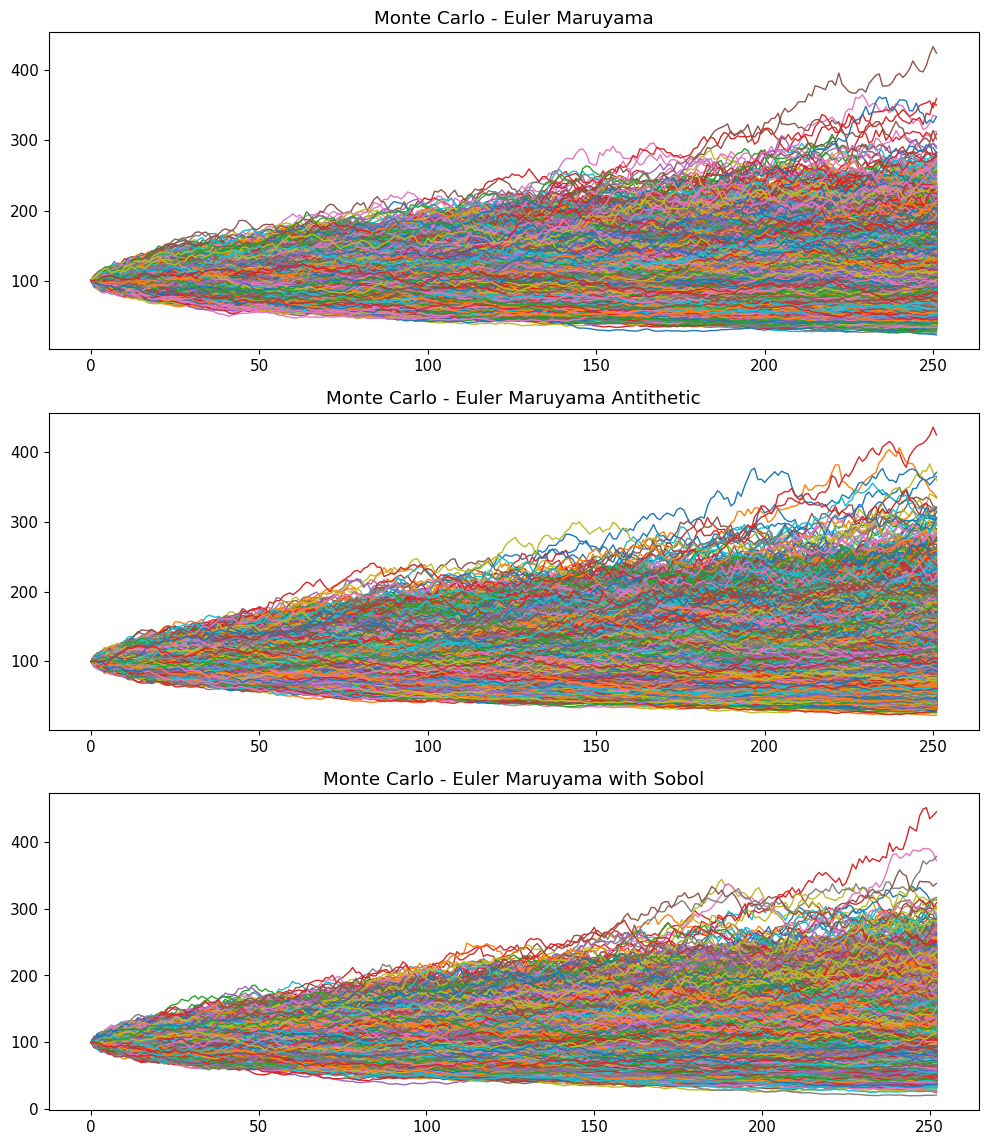

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))

ax1.plot(sim_e_path)
ax1.set_title("Monte Carlo - Euler Maruyama")

ax2.plot(sim_ea_path)
ax2.set_title("Monte Carlo - Euler Maruyama Antithetic")

ax3.plot(sim_se_path)
ax3.set_title("Monte Carlo - Euler Maruyama with Sobol")

plt.show()

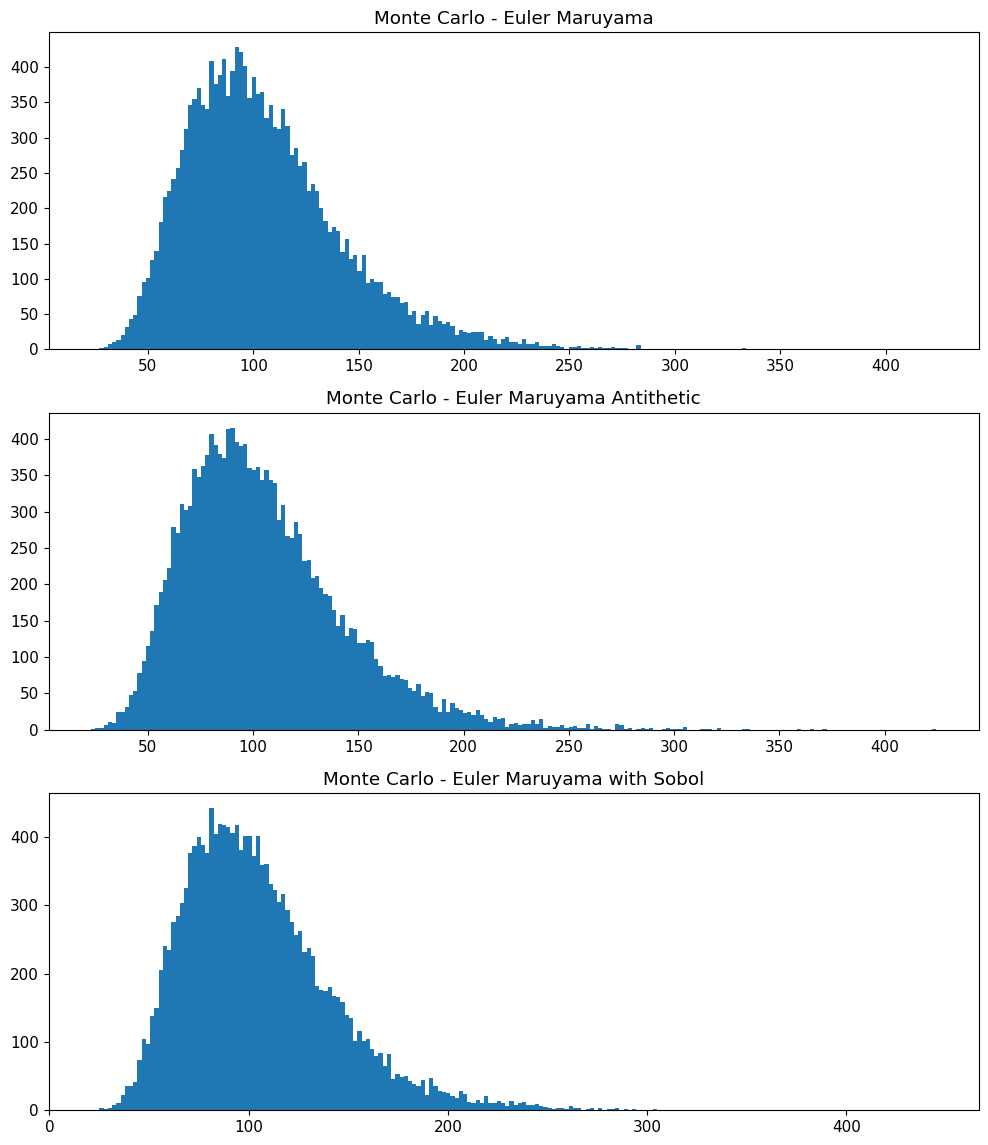

In [6]:
# histogram
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))

ax1.hist(sim_e_path.iloc[-1], bins=200)
ax1.set_title("Monte Carlo - Euler Maruyama")

ax2.hist(sim_ea_path.iloc[-1], bins=200)
ax2.set_title("Monte Carlo - Euler Maruyama Antithetic")

ax3.hist(sim_se_path.iloc[-1], bins=200)
ax3.set_title("Monte Carlo - Euler Maruyama with Sobol")

plt.show()

## 1.2 Simulations of PnLt

Reused the code from the python tutorial for the Black Scholes formula to reduce time to code (made some changes to the code to make it more readable).


In [7]:
class BlackScholes:

    """
    This is a class for Options contract for pricing European options on stocks/index without dividends.

    Attributes:
        spot          : int or float
        strike        : int or float
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
        call_price     : int or float [default None]
        put_price      : int or float [default None]
    """

    def __init__(
        self, spot, strike, rate, dte, volatility, call_price=None, put_price=None
    ):
        # Spot Price
        self.spot = spot

        # Option Strike
        self.strike = strike

        # Interest Rate
        self.rate = rate

        # Days To Expiration
        self.dte = dte

        # Volatility
        self.volatility = volatility

        # Call price # mkt price
        self.call_price = call_price

        # Put price # mkt price
        self.put_price = put_price

        # Utility
        self._a_ = self.volatility * self.dte**0.5

        if self.strike == 0:
            raise ZeroDivisionError("The strike price cannot be zero")
        else:
            self._d1_ = (
                np.log(self.spot / self.strike)
                + (self.rate + (self.volatility**2) / 2) * self.dte
            ) / self._a_

        self._d2_ = self._d1_ - self._a_

        self._b_ = np.e ** -(self.rate * self.dte)

        # The __dict__ attribute
        """
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        """
        for i in [
            "call_price",
            "put_price",
            "call_delta",
            "put_delta",
            "call_theta",
            "put_theta",
            "call_rho",
            "put_rho",
            "vega",
            "gamma",
        ]:
            self.__dict__[i] = None

        [self.call_price, self.put_price] = self._price()
        [self.call_delta, self.put_delta] = self._delta()
        [self.call_theta, self.put_theta] = self._theta()
        [self.call_rho, self.put_rho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()

    # Option Price
    def _price(self):
        """Returns the option price: [Call price, Put price]"""

        if self.volatility == 0 or self.dte == 0:
            call = np.maximum(0.0, self.spot - self.strike)
            put = np.maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * np.e ** (
                -self.rate * self.dte
            ) * norm.cdf(self._d2_)

            put = self.strike * np.e ** (-self.rate * self.dte) * norm.cdf(
                -self._d2_
            ) - self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        """Returns the option delta: [Call delta, Put delta]"""
        #
        # if self.volatility == 0 or self.dte == 0:
        #     call = 1.0 if self.spot > self.strike else 0.0
        #     put = -1.0 if self.spot < self.strike else 0.0
        # else:
        call = norm.cdf(self._d1_)
        put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        """Returns the option gamma"""
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        """Returns the option vega"""
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        """Returns the option theta: [Call theta, Put theta]"""
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (
            2 * self.dte**0.5
        ) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (
            2 * self.dte**0.5
        ) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        """Returns the option rho: [Call rho, Put rho]"""
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]

### Delta Hedge

In [8]:
# Parameters
asset_price = 100
strike_price = 100
risk_free_rate_DH = 0.05
volatility_DH = 0.20
time_to_maturity_DH = 1
shares = 1

In [9]:
# Build the DataFrame
time_st_DH = 1 / 252
time_array_DH = np.arange(0, 1, time_st_DH)

asset_price_DH = np.array([sim_ea_path[777]]).T

# Define Delta replicating vol
delta_bs = []

for i in range(len(asset_price_DH)):
    result_del = BlackScholes(
        asset_price_DH[i][0], strike_price, risk_free_rate_DH, 1, volatility_DH
    ).call_delta
    delta_bs.append(result_del)
    delta_bs_array = np.array(delta_bs)

# Define gamma replicating vol
gamma_bs = []

for i in range(len(asset_price_DH)):
    result_gam = BlackScholes(
        asset_price_DH[i][0], strike_price, risk_free_rate_DH, 1, volatility_DH
    ).gamma
    gamma_bs.append(result_gam)
    gamma_bs_array = np.array(gamma_bs)

In [10]:
# Create the DataFrame
df_DH = pd.DataFrame(
    {
        "time": time_array_DH,
        "asset_price": asset_price_DH[:, 0],
        "delta_bs": delta_bs_array,
        "gamma_bs": gamma_bs_array,
    }
)
df_DH["dDelta"] = (df_DH["delta_bs"] - df_DH["delta_bs"].shift(1)) * shares
df_DH["dDelta"][0] = df_DH["delta_bs"][0] * shares
df_DH["dDeltaS"] = df_DH["dDelta"] * df_DH["asset_price"]

# initial pnl and interest
pnl_values = [df_DH["dDeltaS"][0]]
interest_values = [df_DH["dDeltaS"][0] * (np.exp(risk_free_rate_DH * time_st_DH) - 1)]

# Calculate the pnl and interest
for i in range(1, len(df_DH["dDeltaS"])):
    pnl_next = pnl_values[i - 1] + df_DH["dDeltaS"][i] + interest_values[i - 1]
    pnl_values.append(pnl_next)
    interest = pnl_values[i] * (np.exp(risk_free_rate_DH * time_st_DH) - 1)
    interest_values.append(interest)

df_DH["cum_pnl"] = pnl_values
df_DH["interest"] = interest_values

In [11]:
df_DH

,time,asset_price,delta_bs,gamma_bs,dDelta,dDeltaS,cum_pnl,interest
0,0.000000,100.000000,0.636831,0.018762,0.636831,63.683065,63.683065,0.012637
1,0.003968,101.126359,0.657630,0.018164,0.020799,2.103348,65.799050,0.013057
2,0.007937,102.079184,0.674687,0.017636,0.017057,1.741198,67.553304,0.013405
3,0.011905,99.999792,0.636827,0.018762,-0.037860,-3.786035,63.780674,0.012656
4,0.015873,103.914180,0.706082,0.016574,0.069256,7.196649,70.989978,0.014087
...,...,...,...,...,...,...,...,...
247,0.980159,94.342210,0.523441,0.021107,0.111649,10.533196,66.849241,0.013265
248,0.984127,96.661116,0.571504,0.020304,0.048063,4.645813,71.508319,0.014190
249,0.988095,97.325411,0.584902,0.020029,0.013398,1.303922,72.826431,0.014451
250,0.992063,94.662899,0.530195,0.021011,-0.054707,-5.178712,67.662170,0.013426


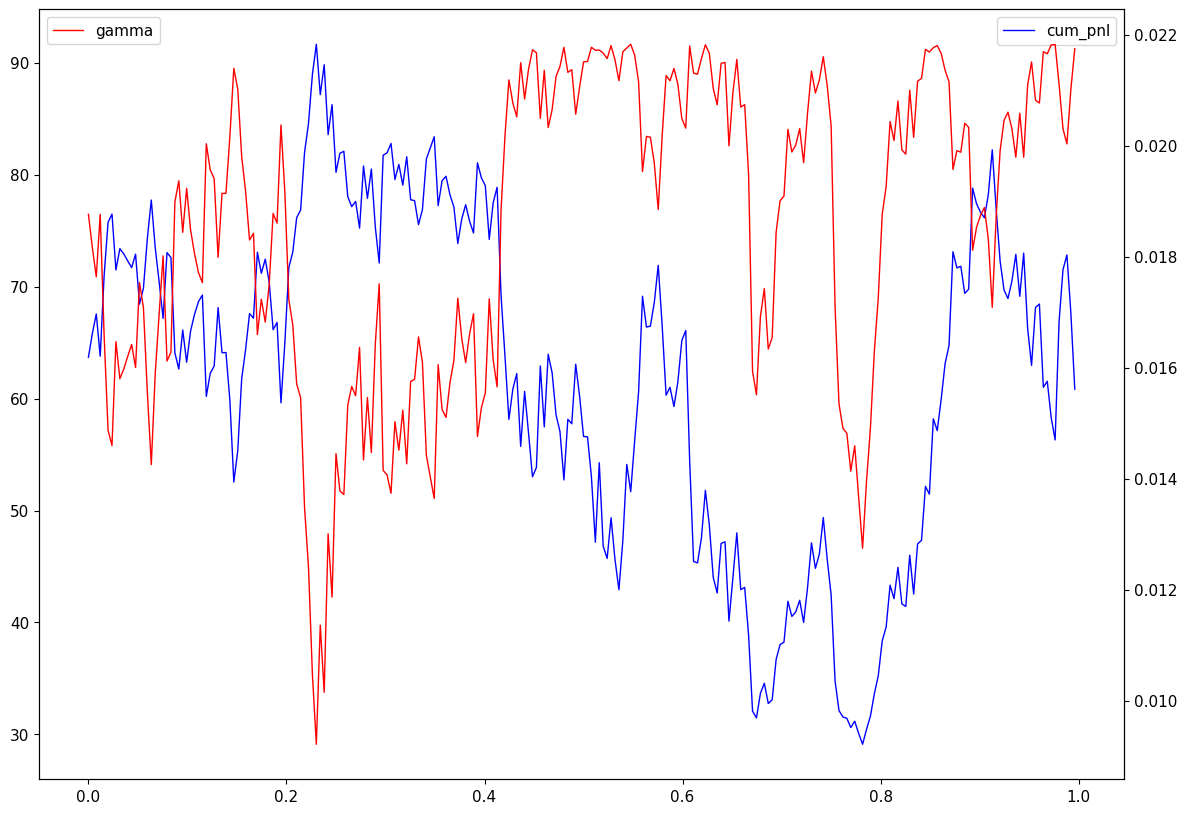

In [12]:
# Plot the cumulative pnl and gamma as a function of time
fig, ax = plt.subplots()
ax.plot(df_DH["time"], df_DH["cum_pnl"], color="blue", label="cum_pnl")
ax.legend(loc="upper right")
ax1 = ax.twinx()
ax1.plot(df_DH["time"], df_DH["gamma_bs"], color="red", label="gamma")
ax1.legend(loc="upper left")
plt.show()

In this section we can clearly see that when gamma spikes, the cumulative PnL also spikes but in the reverse direction. This mean that when the gamma is high, the PnL is low and vice versa.


### Pnl Study

In [13]:
# define time column
time_st = 1 / 252
time_array = np.arange(0, 1, time_st)

In [14]:
# define the asset Path
asset_path_sigma_a = np.array([sim_ea_path[25]]).T

In [15]:
# define the option call and calculate the price based on the asset path
# parameters
sigma_imp = 0.20
sigma_ac = 0.35
strike_pnl = 100
risk_free_rate_pnl = 0.05

# Calculate the option price based on the asset path
opt_sigma_i = []

for i in range(len(asset_path_sigma_a)):
    result = BlackScholes(
        asset_path_sigma_a[i][0], strike_pnl, risk_free_rate_pnl, 1, sigma_imp
    ).call_price
    opt_sigma_i.append(result)
    opt_sigma_i_array = np.array(opt_sigma_i)


# Define Delta replicating vol
delta_replicating_vol = []

for i in range(len(asset_path_sigma_a)):
    result2 = BlackScholes(
        asset_path_sigma_a[i][0], strike_pnl, risk_free_rate_pnl, 1, sigma_ac
    ).call_delta
    delta_replicating_vol.append(result2)
    delta_replicating_vol_array = np.array(delta_replicating_vol)


# Define gamma replicating vol
gamma_replicating_vol = []

for i in range(len(asset_path_sigma_a)):
    result3 = BlackScholes(
        asset_path_sigma_a[i][0], strike_pnl, risk_free_rate_pnl, 1, sigma_ac
    ).gamma
    gamma_replicating_vol.append(result3)
    gamma_replicating_vol_array = np.array(gamma_replicating_vol)

# Calculate the return of the asset path
asset_path_sigma_a_return = (
    np.diff(asset_path_sigma_a, axis=0) / asset_path_sigma_a[:-1]
)
asset_path_sigma_a_return = np.insert(asset_path_sigma_a_return, 0, 0, axis=0)

In [16]:
# create the dataframe to store the data
df = pd.DataFrame(
    {
        "time": time_array,
        "asset_path_sigma_a": asset_path_sigma_a[:, 0],
        "asset_path_return": asset_path_sigma_a_return[:, 0],
        "option_price_sigma_imp": opt_sigma_i_array,
        "delta_replicating_vol_sigma_a": delta_replicating_vol_array,
        "gamma_replicating_vol_sigma_a": gamma_replicating_vol_array,
    }
)
df["Portfolio"] = (
    df["option_price_sigma_imp"]
    - df["delta_replicating_vol_sigma_a"] * df["asset_path_sigma_a"]
)
df["Cashflow_replication"] = (
    df["delta_replicating_vol_sigma_a"] - df["delta_replicating_vol_sigma_a"].shift(1)
) * df["asset_path_sigma_a"]
df["Cashflow_replication"][0] = 0

cash_values = [-df["Portfolio"][0]]
for i in range(1, len(df["Cashflow_replication"])):
    cash_next = df["Cashflow_replication"][i] + cash_values[i - 1] * np.exp(
        risk_free_rate_pnl * time_st
    )
    cash_values.append(cash_next)

df["Cash_on_account"] = cash_values
df["PnL_cumulative"] = df["Cash_on_account"] + df["Portfolio"]
df["PnL realised"] = (
    1
    / 2
    * df["gamma_replicating_vol_sigma_a"]
    * df["asset_path_sigma_a"] ** 2
    * (df["asset_path_return"] ** 2 - sigma_ac**2 * time_st)
)

df

,time,asset_path_sigma_a,asset_path_return,option_price_sigma_imp,delta_replicating_vol_sigma_a,gamma_replicating_vol_sigma_a,Portfolio,Cashflow_replication,Cash_on_account,PnL_cumulative,PnL realised
0,0.000000,100.000000,0.000000,10.450584,0.624703,0.010837,-52.019751,0.000000,52.019751,0.000000,-0.026340
1,0.003968,99.437971,-0.005620,10.095645,0.618580,0.010953,-51.414711,-0.608878,51.421196,0.006485,-0.024612
2,0.007937,98.208767,-0.012362,9.340453,0.604963,0.011202,-50.072242,-1.337300,50.094099,0.021857,-0.018006
3,0.011905,94.210107,-0.040716,7.093042,0.558611,0.011968,-45.533792,-4.366818,45.737222,0.203429,0.062229
4,0.015873,94.210903,0.000008,7.093456,0.558621,0.011968,-45.534719,0.000896,45.747194,0.212475,-0.025818
...,...,...,...,...,...,...,...,...,...,...,...
247,0.980159,63.846713,-0.039031,0.134160,0.167498,0.011217,-10.560026,-1.919754,21.985300,11.425274,0.023716
248,0.984127,63.462916,-0.006011,0.123349,0.163216,0.011097,-10.234799,-0.271753,21.717910,11.483111,-0.010056
249,0.988095,63.035826,-0.006730,0.112172,0.158505,0.010961,-9.879341,-0.296927,21.425292,11.545952,-0.009599
250,0.992063,60.439554,-0.041187,0.060774,0.131189,0.010063,-7.868211,-1.651005,19.778539,11.910328,0.022246


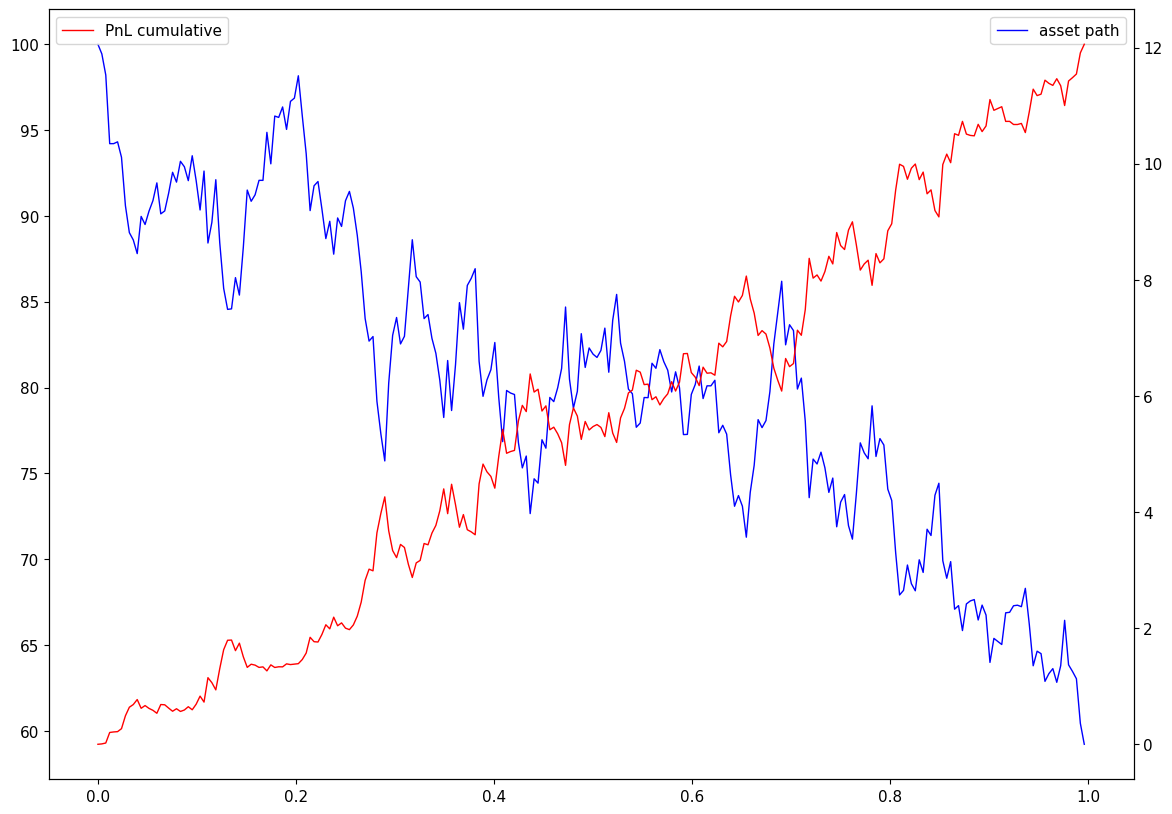

In [17]:
# plot asset path, PnL as a function of time
fig, ax1 = plt.subplots()
ax1.plot(df["time"], df["asset_path_sigma_a"], color="blue", label="asset path")
ax1.legend(loc="upper right")
ax2 = ax1.twinx()
ax2.plot(df["time"], df["PnL_cumulative"], color="red", label="PnL cumulative")
ax2.legend(loc="upper left")
plt.show()

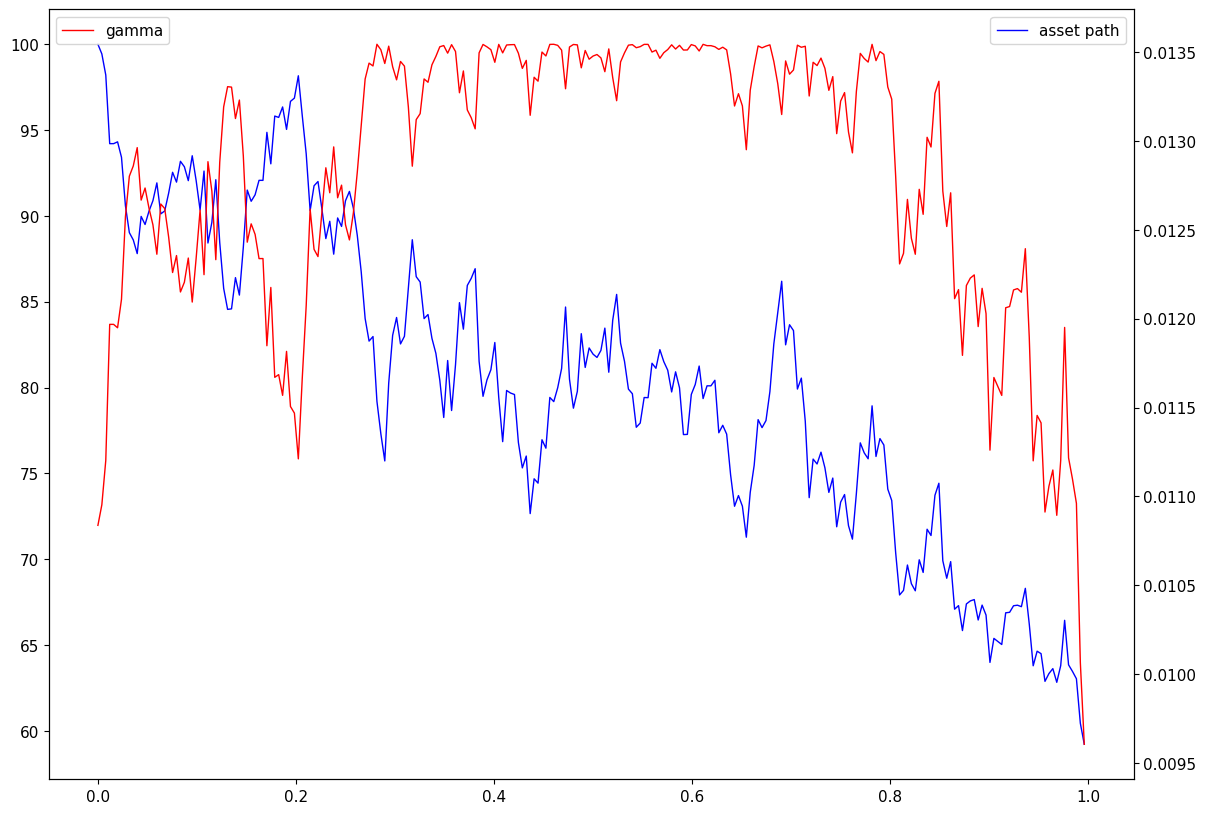

In [18]:
# plot asset path, gamma as a function of time
fig3, ax3 = plt.subplots()
ax3.plot(df["time"], df["asset_path_sigma_a"], color="blue", label="asset path")
ax3.legend(loc="upper right")
ax4 = ax3.twinx()
ax4.plot(df["time"], df["gamma_replicating_vol_sigma_a"], color="red", label="gamma")
ax4.legend(loc="upper left")
plt.show()

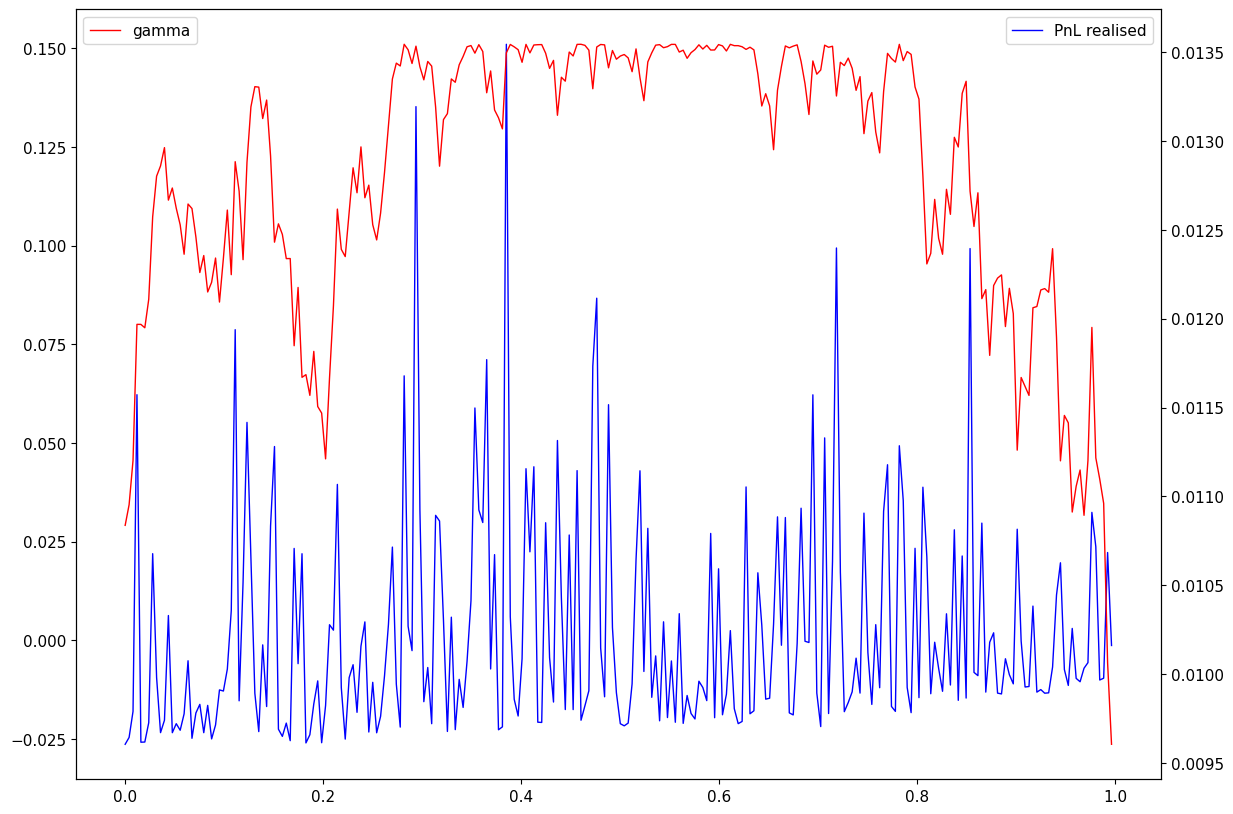

In [19]:
# plot PnL realized, gamma as a function of time
fig4, ax5 = plt.subplots()
ax5.plot(df["time"], df["PnL realised"], color="blue", label="PnL realised")
ax5.legend(loc="upper right")
ax6 = ax5.twinx()
ax6.plot(df["time"], df["gamma_replicating_vol_sigma_a"], color="red", label="gamma")
ax6.legend(loc="upper left")
plt.show()

In [20]:
# compare actual PnL and theoretical PnL
va = BlackScholes(100, 100, 0.05, 1, 0.35).call_price
vi = BlackScholes(100, 100, 0.05, 1, 0.20).call_price
theoretical_pnl = va - vi
actual_pnl = np.exp(-risk_free_rate_pnl * 1) * df["PnL_cumulative"][len(df["PnL_cumulative"]) - 1]
total_pnl = df["PnL realised"].sum()

print("theoretical PnL is: ", theoretical_pnl)
print("actual PnL is: ", actual_pnl)
print("total PnL is: ", total_pnl)

theoretical PnL is:  5.677845309390314
actual PnL is:  11.470143748628317
total PnL is:  0.459683823515013


# Part 2: Advanced Greeks

## 1. Minimum Variance delta

### Adjustment for expected changes in sigma implied for changes in asset price

In [21]:
# Define the function for computing the adjustment
def compute_adjustment(S, sigma_imp, r, T, K):
    d1 = (np.log(S/K) + (r + 0.5 * sigma_imp**2) * T) / (sigma_imp * np.sqrt(T))
    adjustment = -d1 / (S * sigma_imp * np.sqrt(T)) * np.exp(-0.5 * d1**2) * np.sqrt(T)
    return adjustment

# Set the parameters
S = 100
sigma_imp = 0.2
r = 0.05
T = 1
K = 100

# Compute the adjustment
adjustment = compute_adjustment(S, sigma_imp, r, T, K)

# Print the result
print("The adjustment is:", adjustment)

The adjustment is: -0.016460291108875987


In [22]:
# get historical at the money option data for SPX from yahoo finance
spx = pd.read_excel(r"C:\Users\renar\OneDrive\Bureau\Part2_data.xlsx")
date_spx = np.array([spx["Date"]])
spx_delta = np.array([spx["Delta"]])
spx_imp_vol = np.array([spx["IV"]])

spx_change_imp_vol = np.diff(spx_imp_vol, axis=1)
spx_change_imp_vol = np.insert(spx_change_imp_vol, 0, 0, axis=1)
spx_change_imp_vol = spx_change_imp_vol.T

spx_underlying = np.array([spx["Price_under"]])

spx_return = np.diff(spx_underlying, axis=1) / spx_underlying[:, :-1] * np.sqrt(22)
spx_return = spx_return.T
spx_return = np.insert(spx_return, 0, 0, axis=0)

In [39]:
len(spx['Date'])

20

In [24]:
# Define the data
S = spx_underlying
sigma_imp = spx_imp_vol

# Reshape the data
S = np.array(S).reshape(-1, 1)
sigma_imp = np.array(sigma_imp).reshape(-1, 1)

# Fit the polynomial regression model
poly = PolynomialFeatures(degree=2)
S_poly = poly.fit_transform(S)
model = LinearRegression().fit(S_poly, sigma_imp)

# Print the coefficients of the polynomial regression model
print("Coefficients:", model.coef_)

Coefficients: [[ 0.00000000e+00 -5.45672010e-01  5.97328561e-05]]


Quadratic coefficients: [ 0.97611482 -2.41568625 13.19340911]


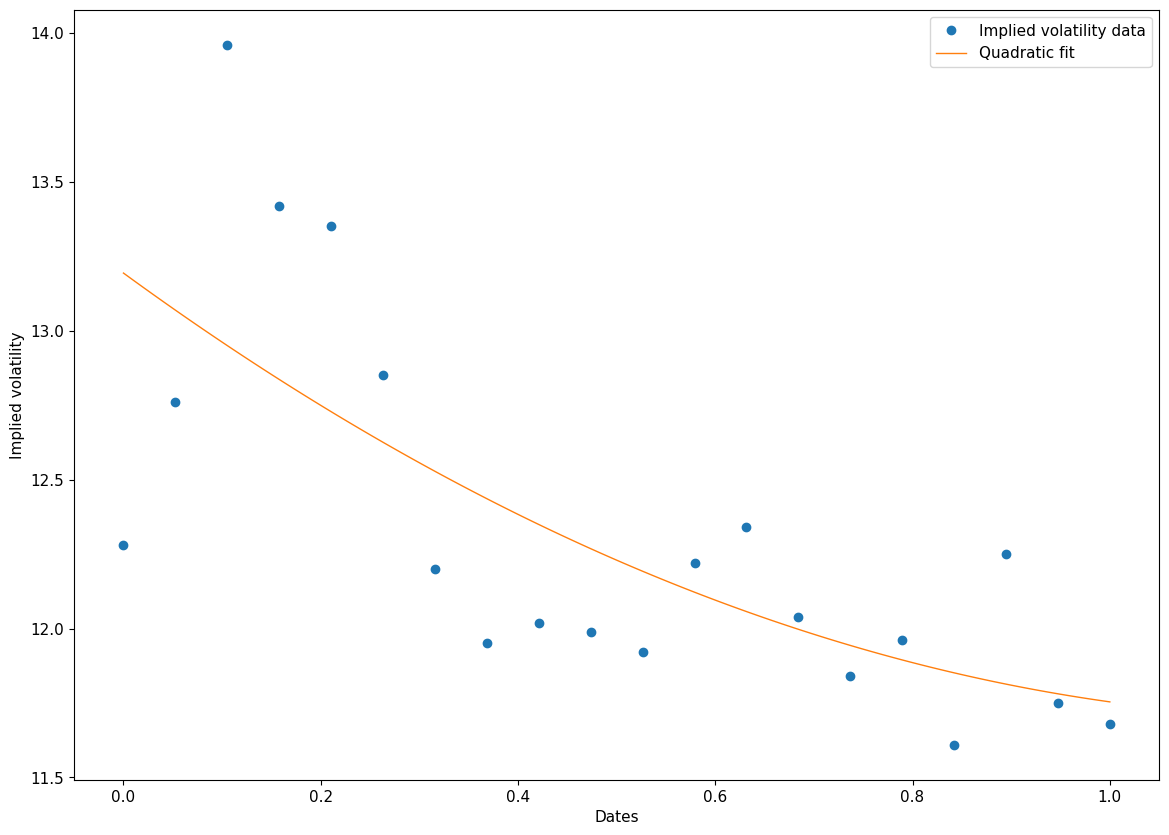

In [42]:
# Define the implied volatility data
implied_vol = spx["IV"].to_list()

# Define the time to maturity data in years
hist_days = np.linspace(0, 1, 20)

# Define the quadratic function to fit
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the quadratic function to the data
popt, pcov = curve_fit(quadratic_func, hist_days, implied_vol)

# Compute the implied volatility curve using the fitted function
curve_x = np.linspace(0, 1, 100)
curve_y = quadratic_func(curve_x, *popt)

# Print the quadratic coefficients
print("Quadratic coefficients:", popt)


# Plot the implied volatility data and the fitted curve
plt.plot(hist_days, implied_vol, 'o', label='Implied volatility data')
plt.plot(curve_x,curve_y, label='Quadratic fit')
plt.xlabel('Dates')
plt.ylabel('Implied volatility')
plt.legend()
plt.show()

We can clearly see that quadratic fit isn't realy a good fit, although the data is fitting only has 20 data points for implied volality (ATM implied volatility for the same maturity over 20 days - jully 2023 - SPX ). To make a better fit I could have use more data or even generated it.

# Part 3: Local Volatility addition

In [82]:

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the price of a European call option using the Black-Scholes formula.
    
    Parameters:
    S (float): underlying asset price
    K (float): strike price
    T (float): time to maturity (in years)
    r (float): risk-free interest rate
    sigma (float): volatility of the underlying asset
    
    Returns:
    float: call option price
    """
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call_price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call_price

def implied_volatility(S, K, T, r, C, a=500, b=0, tol=1e-6, max_iter=100000):
    """
    Calculates the implied volatility of a European call option using the bisection method.
    
    Parameters:
    S (float): underlying asset price
    K (float): strike price
    T (float): time to maturity (in years)
    r (float): risk-free interest rate
    C (float): call option price
    a (float): lower bound of volatility (default is 0.001)
    b (float): upper bound of volatility (default is 1)
    tol (float): tolerance for convergence (default is 1e-6)
    max_iter (int): maximum number of iterations (default is 100)
    
    Returns:
    float: implied volatility
    """
    # Implement bisection method
    fa = C - black_scholes_call(S, K, T, r, a)
    fb = C - black_scholes_call(S, K, T, r, b)
    c=0
    for i in range(max_iter):
        c = (a + b) / 2
        fc = C - black_scholes_call(S, K, T, r, c)
        if abs(fc) < tol:
            break
        if fc*fa < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
    
    return c

In [83]:
def local_volatility_surface(S, K, T, r, C, a=500, b=0, tol=1e-6, max_iter=100000, interp_method='cubic'):
    """
    Calculates the local volatility surface using Dupire's formula.
    
    Parameters:
    S (float): underlying asset price
    K (ndarray): array of strike prices
    T (ndarray): array of time to maturity
    r (float): risk-free interest rate
    C (ndarray): array of call option prices
    a (float): lower bound of volatility (default is 0.001)
    b (float): upper bound of volatility (default is 1)
    tol (float): tolerance for convergence (default is 1e-6)
    max_iter (int): maximum number of iterations (default is 100)
    interp_method (str): interpolation method to use (default is 'cubic')
    
    Returns:
    ndarray: local volatility surface
    """
    
    # Calculate implied volatility surface
    implied_vol_surface = np.zeros((len(K), len(T)))
    for i in range(len(K)):
        for j in range(len(T)):
            implied_vol_surface[i][j] = implied_volatility(S, K[i], T[j], r, C[i][j], a, b, tol, max_iter)
    
    # Calculate partial derivatives of implied volatility surface
    dK = np.gradient(K)
    dT = np.gradient(T)
    dC_dK = np.gradient(C, axis=0) / dK[:, None]
    dC_dT = np.gradient(C, axis=1) / dT[None, :]
    d2C_dK2 = np.gradient(dC_dK, axis=0) / dK[:, None]
    d2C_dKdT = np.gradient(dC_dK, axis=1) / dT[None, :]
    d2C_dT2 = np.gradient(dC_dT, axis=1) / dT[None, :]
    
    # Calculate local volatility surface using Dupire's formula
    local_vol_surface = np.zeros((len(T), len(K)))
    for i in range(len(T)):
        for j in range(len(K)):
            if C[j][i] > 0:
                d1 = (np.log(S/K[j]) + (r + implied_vol_surface[j][i]**2/2)*T[i]) / (implied_vol_surface[j][i]*np.sqrt(T[i]))
                d2 = d1 - implied_vol_surface[j][i]*np.sqrt(T[i])
                local_vol_surface[i][j] = np.sqrt(2*dC_dT[j][i] / (K[j]**2 * d2**2 * T[i])) - (dC_dK[j][i] / (K[j] * d1 * d2 * T[i]))
    
    # Interpolate local volatility surface
    f = interp2d(K, T, local_vol_surface, kind=interp_method)
    local_vol_surface_interp = f(K, T)
    
    return local_vol_surface_interp

C:\Users\renar\AppData\Local\Temp\ipykernel_20380\3871251837.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
C:\Users\renar\AppData\Local\Temp\ipykernel_20380\1464517262.py:46: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(K, T, local_vol_surface, kind=interp_method)
C:\Users\renar\AppData\Local\Temp\ipykernel_20380\1464517262.py:47: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 

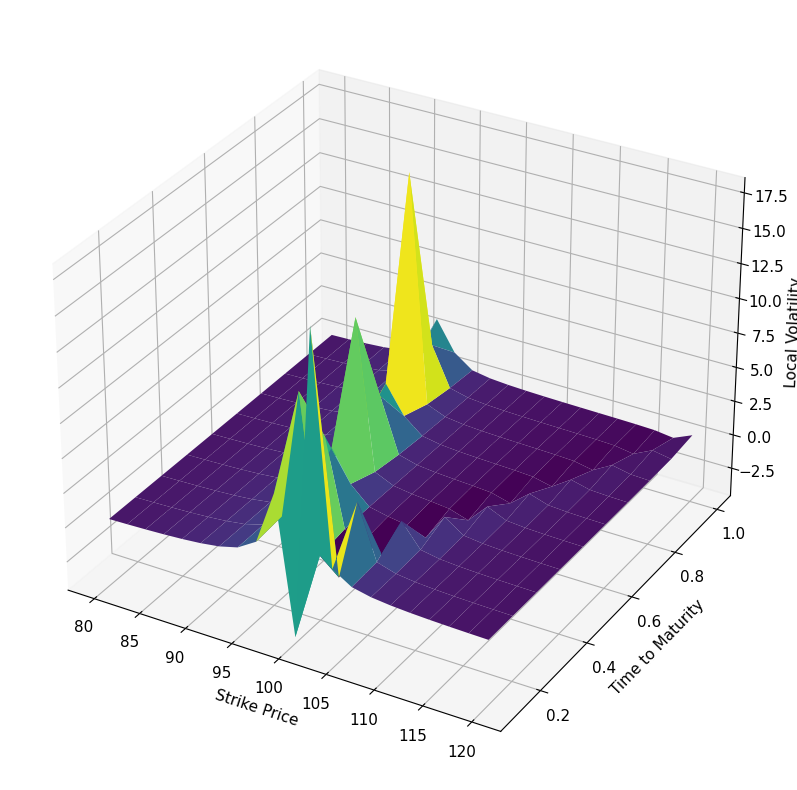

In [84]:
# Sample data
S = 100
K = np.linspace(80, 120, 21)
T = np.linspace(0.1, 1, 10)
r = 0.05
C = np.zeros((len(K), len(T)))
sigma = 0.5
for i in range(len(K)):
    for j in range(len(T)):
        C[i][j] = black_scholes_call(S, K[i], T[j], r, sigma)

# Calculate local volatility surface
local_vol_surface = local_volatility_surface(S, K, T, r, C, a=500, b=0, tol=1e-6, max_iter=100000, interp_method='cubic')

# Plot local volatility surface
K, T = np.meshgrid(K, T)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(K, T, local_vol_surface, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Local Volatility')
plt.show()

Although far from being perfect, by twicking the code a bit we could get a better surface. You will notice that in the surdace, there are negative implied volatility which result from model miss specification   